In [9]:
%%capture

!pip install snowflake-connector-python

In [10]:
%%capture

!pip install snowflake-sqlalchemy

In [11]:
%%capture

!pip install xgboost

In [12]:
import os
import pickle
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics

import sqlalchemy
import snowflake.connector
from sqlalchemy import create_engine
from snowflake.sqlalchemy import *

import xgboost
from datetime import datetime, timedelta
import time  
import pytz    
tz_NY = pytz.timezone('Europe/London')

import snowflake_creds

import warnings
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/snowflake/sqlalchemy/base.py:1068: SAWarning: The GenericFunction 'flatten' is already registered and is going to be overridden.
  functions.register_function("flatten", flatten)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [13]:
# Creating a Snowflake connection engine
engine = create_engine(URL(
        account="vvkvijp-xf90326",
        user= snowflake_creds.USER_NAME,
        password= snowflake_creds.PASSWORD,
        role="ACCOUNTADMIN",
        warehouse="COMPUTE_WH",
        database="HEALTHDB",
        schema="HEALTHSCHEMA"
    ))

In [14]:
query = """
WITH BASE AS (
    SELECT 
        CASE_ID,
        COALESCE(HOSPITAL_CODE, 0) AS HOSPITAL_CODE,
        COALESCE(HOSPITAL_TYPE_CODE, 'None') AS HOSPITAL_TYPE_CODE,
        COALESCE(CITY_CODE_HOSPITAL, 0) AS CITY_CODE_HOSPITAL,
        COALESCE(HOSPITAL_REGION_CODE, 'None') AS HOSPITAL_REGION_CODE,
        COALESCE(AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL, 0) AS AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,
        COALESCE(DEPARTMENT, 'None') AS DEPARTMENT,
        COALESCE(WARD_TYPE, 'None') AS WARD_TYPE,
        COALESCE(WARD_FACILITY_CODE, 'None') AS WARD_FACILITY_CODE,
        COALESCE(BED_GRADE, 0) AS BED_GRADE,
        PATIENTID,
        COALESCE(CITY_CODE_PATIENT, 0) AS CITY_CODE_PATIENT,
        COALESCE(TYPE_OF_ADMISSION, 'None') AS TYPE_OF_ADMISSION,
        COALESCE(SEVERITY_OF_ILLNESS, 'Minor') AS SEVERITY_OF_ILLNESS,
        COALESCE(VISITORS_WITH_PATIENT, 0) AS VISITORS_WITH_PATIENT,
        COALESCE(AGE, 'None') AS AGE,
        COALESCE(ADMISSION_DEPOSIT, 0) AS ADMISSION_DEPOSIT,
        ADMISSION_DATE,
        DISCHARGE_DATE
    FROM HEALTHDB.HEALTHSCHEMA.HEALTH_DATA
),

BASE_WITH_FEATURES AS (
    SELECT 
        *,
        MONTHNAME(ADMISSION_DATE) AS ADMISSION_MONTH,
        DAYNAME(ADMISSION_DATE) AS ADMISSION_DAY,
        CONCAT(TYPE_OF_ADMISSION, '-', SEVERITY_OF_ILLNESS) AS ADMISSION_ILLNESS,
        CONCAT(SEVERITY_OF_ILLNESS, '-', BED_GRADE) AS ILLNESS_BEDGRADE,
        CONCAT(DEPARTMENT, '-', SEVERITY_OF_ILLNESS) AS DEPARTMENT_ILLNESS,
        DATEDIFF(day, ADMISSION_DATE, DISCHARGE_DATE) AS LOS
    FROM BASE
)    

SELECT * 
FROM BASE_WITH_FEATURES
"""

In [15]:
with engine.connect() as conn:
    data = pd.DataFrame(pd.read_sql(query,conn))
    data.columns = [col.upper() for col in data.columns.tolist()]

In [16]:
print(data.shape)
data.head()

(236704, 25)


,CASE_ID,HOSPITAL_CODE,HOSPITAL_TYPE_CODE,CITY_CODE_HOSPITAL,HOSPITAL_REGION_CODE,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,DEPARTMENT,WARD_TYPE,WARD_FACILITY_CODE,BED_GRADE,PATIENTID,CITY_CODE_PATIENT,TYPE_OF_ADMISSION,SEVERITY_OF_ILLNESS,VISITORS_WITH_PATIENT,AGE,ADMISSION_DEPOSIT,ADMISSION_DATE,DISCHARGE_DATE,ADMISSION_MONTH,ADMISSION_DAY,ADMISSION_ILLNESS,ILLNESS_BEDGRADE,DEPARTMENT_ILLNESS,LOS
0,1,8,c,3,Z,3,radiotherapy,R,F,2,31397,7,Emergency,Extreme,2,51-60,4911,2022-08-10,2022-08-20,Aug,Wed,Emergency-Extreme,Extreme-2,radiotherapy-Extreme,10
1,3,10,e,1,X,2,anesthesia,S,E,2,31397,7,Trauma,Extreme,2,51-60,4745,2022-09-09,2022-10-19,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,40
2,4,26,b,2,Y,2,radiotherapy,R,D,2,31397,7,Trauma,Extreme,2,51-60,7272,2022-09-22,2022-11-11,Sep,Thu,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50
3,5,26,b,2,Y,2,radiotherapy,S,D,2,31397,7,Trauma,Extreme,2,51-60,5558,2022-11-02,2022-12-22,Nov,Wed,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50
4,6,23,a,6,X,2,anesthesia,S,F,2,31397,7,Trauma,Extreme,2,51-60,4449,2022-09-16,2022-10-06,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,20


## Preprocessing:

* Dropping unwanted columns
* One-Hot encoding categorical columns
* Setting the CASE_ID as index

In [17]:
cols_to_drop = ['HOSPITAL_CODE','PATIENTID','ADMISSION_DATE','DISCHARGE_DATE']

In [18]:
data_pre = data.copy()

In [19]:
# Dropping columns

print("Before dropping: ", data_pre.shape)
data_pre = data_pre.drop(cols_to_drop,axis=1)
print("After dropping: ", data_pre.shape)

Before dropping:  (236704, 25)
After dropping:  (236704, 21)


In [20]:
data_pre.set_index('CASE_ID',inplace=True)

In [21]:
data_pre.head(3)

,HOSPITAL_TYPE_CODE,CITY_CODE_HOSPITAL,HOSPITAL_REGION_CODE,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,DEPARTMENT,WARD_TYPE,WARD_FACILITY_CODE,BED_GRADE,CITY_CODE_PATIENT,TYPE_OF_ADMISSION,SEVERITY_OF_ILLNESS,VISITORS_WITH_PATIENT,AGE,ADMISSION_DEPOSIT,ADMISSION_MONTH,ADMISSION_DAY,ADMISSION_ILLNESS,ILLNESS_BEDGRADE,DEPARTMENT_ILLNESS,LOS
CASE_ID,,,,,,,,,,,,,,,,,,,,
1,c,3,Z,3,radiotherapy,R,F,2,7,Emergency,Extreme,2,51-60,4911,Aug,Wed,Emergency-Extreme,Extreme-2,radiotherapy-Extreme,10
3,e,1,X,2,anesthesia,S,E,2,7,Trauma,Extreme,2,51-60,4745,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,40
4,b,2,Y,2,radiotherapy,R,D,2,7,Trauma,Extreme,2,51-60,7272,Sep,Thu,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50


In [22]:
# Fixing the data types issue
num_columns = ['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL','VISITORS_WITH_PATIENT','ADMISSION_DEPOSIT','LOS']
cat_columns = [col for col in data_pre.columns.tolist() if col not in num_columns]

In [23]:
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236704 entries, 1 to 255883
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   HOSPITAL_TYPE_CODE                 236704 non-null  object
 1   CITY_CODE_HOSPITAL                 236704 non-null  int64 
 2   HOSPITAL_REGION_CODE               236704 non-null  object
 3   AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  236704 non-null  int64 
 4   DEPARTMENT                         236704 non-null  object
 5   WARD_TYPE                          236704 non-null  object
 6   WARD_FACILITY_CODE                 236704 non-null  object
 7   BED_GRADE                          236704 non-null  int64 
 8   CITY_CODE_PATIENT                  236704 non-null  int64 
 9   TYPE_OF_ADMISSION                  236704 non-null  object
 10  SEVERITY_OF_ILLNESS                236704 non-null  object
 11  VISITORS_WITH_PATIENT              236704 non-null  int64

In [24]:
for col in cat_columns:
    data_pre[col] = data_pre[col].astype(object)
    
for col in num_columns:
    data_pre[col] = data_pre[col].astype(int)    

In [25]:
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236704 entries, 1 to 255883
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   HOSPITAL_TYPE_CODE                 236704 non-null  object
 1   CITY_CODE_HOSPITAL                 236704 non-null  object
 2   HOSPITAL_REGION_CODE               236704 non-null  object
 3   AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  236704 non-null  int64 
 4   DEPARTMENT                         236704 non-null  object
 5   WARD_TYPE                          236704 non-null  object
 6   WARD_FACILITY_CODE                 236704 non-null  object
 7   BED_GRADE                          236704 non-null  object
 8   CITY_CODE_PATIENT                  236704 non-null  object
 9   TYPE_OF_ADMISSION                  236704 non-null  object
 10  SEVERITY_OF_ILLNESS                236704 non-null  object
 11  VISITORS_WITH_PATIENT              236704 non-null  int64

In [26]:
print("After dropping: ", data_pre.shape)

After dropping:  (236704, 20)


In [27]:
# One-Hot Encoding
data_after_process = pd.get_dummies(data_pre, drop_first=True)

In [28]:
print(data_after_process.shape)
data_after_process.head()

(236704, 134)


,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,VISITORS_WITH_PATIENT,ADMISSION_DEPOSIT,LOS,HOSPITAL_TYPE_CODE_b,HOSPITAL_TYPE_CODE_c,HOSPITAL_TYPE_CODE_d,HOSPITAL_TYPE_CODE_e,HOSPITAL_TYPE_CODE_f,HOSPITAL_TYPE_CODE_g,CITY_CODE_HOSPITAL_2,CITY_CODE_HOSPITAL_3,CITY_CODE_HOSPITAL_4,CITY_CODE_HOSPITAL_5,CITY_CODE_HOSPITAL_6,CITY_CODE_HOSPITAL_7,CITY_CODE_HOSPITAL_9,CITY_CODE_HOSPITAL_10,CITY_CODE_HOSPITAL_11,CITY_CODE_HOSPITAL_13,HOSPITAL_REGION_CODE_Y,HOSPITAL_REGION_CODE_Z,DEPARTMENT_anesthesia,DEPARTMENT_gynecology,DEPARTMENT_radiotherapy,DEPARTMENT_surgery,WARD_TYPE_Q,WARD_TYPE_R,WARD_TYPE_S,WARD_TYPE_T,WARD_TYPE_U,WARD_FACILITY_CODE_B,WARD_FACILITY_CODE_C,WARD_FACILITY_CODE_D,WARD_FACILITY_CODE_E,WARD_FACILITY_CODE_F,BED_GRADE_1,BED_GRADE_2,BED_GRADE_3,BED_GRADE_4,CITY_CODE_PATIENT_1,CITY_CODE_PATIENT_2,CITY_CODE_PATIENT_3,CITY_CODE_PATIENT_4,CITY_CODE_PATIENT_5,CITY_CODE_PATIENT_6,CITY_CODE_PATIENT_7,CITY_CODE_PATIENT_8,CITY_CODE_PATIENT_9,CITY_CODE_PATIENT_10,CITY_CODE_PATIENT_11,CITY_CODE_PATIENT_12,CITY_CODE_PATIENT_13,CITY_CODE_PATIENT_14,CITY_CODE_PATIENT_15,CITY_CODE_PATIENT_16,CITY_CODE_PATIENT_18,CITY_CODE_PATIENT_19,CITY_CODE_PATIENT_20,CITY_CODE_PATIENT_21,CITY_CODE_PATIENT_22,CITY_CODE_PATIENT_23,CITY_CODE_PATIENT_24,CITY_CODE_PATIENT_25,CITY_CODE_PATIENT_26,CITY_CODE_PATIENT_27,CITY_CODE_PATIENT_28,CITY_CODE_PATIENT_29,CITY_CODE_PATIENT_30,CITY_CODE_PATIENT_31,CITY_CODE_PATIENT_32,CITY_CODE_PATIENT_33,CITY_CODE_PATIENT_34,CITY_CODE_PATIENT_35,CITY_CODE_PATIENT_36,CITY_CODE_PATIENT_37,TYPE_OF_ADMISSION_Trauma,TYPE_OF_ADMISSION_Urgent,SEVERITY_OF_ILLNESS_Minor,SEVERITY_OF_ILLNESS_Moderate,AGE_20-Nov,AGE_21-30,AGE_31-40,AGE_41-50,AGE_51-60,AGE_61-70,AGE_71-80,AGE_81-90,AGE_91-100,ADMISSION_MONTH_Nov,ADMISSION_MONTH_Oct,ADMISSION_MONTH_Sep,ADMISSION_DAY_Mon,ADMISSION_DAY_Sat,ADMISSION_DAY_Sun,ADMISSION_DAY_Thu,ADMISSION_DAY_Tue,ADMISSION_DAY_Wed,ADMISSION_ILLNESS_Emergency-Minor,ADMISSION_ILLNESS_Emergency-Moderate,ADMISSION_ILLNESS_Trauma-Extreme,ADMISSION_ILLNESS_Trauma-Minor,ADMISSION_ILLNESS_Trauma-Moderate,ADMISSION_ILLNESS_Urgent-Extreme,ADMISSION_ILLNESS_Urgent-Minor,ADMISSION_ILLNESS_Urgent-Moderate,ILLNESS_BEDGRADE_Extreme-1,ILLNESS_BEDGRADE_Extreme-2,ILLNESS_BEDGRADE_Extreme-3,ILLNESS_BEDGRADE_Extreme-4,ILLNESS_BEDGRADE_Minor-0,ILLNESS_BEDGRADE_Minor-1,ILLNESS_BEDGRADE_Minor-2,ILLNESS_BEDGRADE_Minor-3,ILLNESS_BEDGRADE_Minor-4,ILLNESS_BEDGRADE_Moderate-0,ILLNESS_BEDGRADE_Moderate-1,ILLNESS_BEDGRADE_Moderate-2,ILLNESS_BEDGRADE_Moderate-3,ILLNESS_BEDGRADE_Moderate-4,DEPARTMENT_ILLNESS_TB & Chest disease-Minor,DEPARTMENT_ILLNESS_TB & Chest disease-Moderate,DEPARTMENT_ILLNESS_anesthesia-Extreme,DEPARTMENT_ILLNESS_anesthesia-Minor,DEPARTMENT_ILLNESS_anesthesia-Moderate,DEPARTMENT_ILLNESS_gynecology-Extreme,DEPARTMENT_ILLNESS_gynecology-Minor,DEPARTMENT_ILLNESS_gynecology-Moderate,DEPARTMENT_ILLNESS_radiotherapy-Extreme,DEPARTMENT_ILLNESS_radiotherapy-Minor,DEPARTMENT_ILLNESS_radiotherapy-Moderate,DEPARTMENT_ILLNESS_surgery-Extreme,DEPARTMENT_ILLNESS_surgery-Minor,DEPARTMENT_ILLNESS_surgery-Moderate
CASE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,2,4911,10,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,2,2,4745,40,False,

In [29]:
%%writefile LOS_Preprocessing.py

import pandas as pd
import numpy as np

## Preprocessing Function
def preprocess_data(df):
    # Columns to drop
    cols_to_drop = ['HOSPITAL_CODE','PATIENTID','ADMISSION_DATE','DISCHARGE_DATE']
    df = df.drop(cols_to_drop,axis=1)
    
    # Setting the index
    df.set_index('CASE_ID',inplace=True)

    # Fixing the data types issue
    num_columns = ['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL','VISITORS_WITH_PATIENT','ADMISSION_DEPOSIT','LOS']
    cat_columns = [col for col in df.columns.tolist() if col not in num_columns]
    
    for col in cat_columns:
        df[col] = df[col].astype(object)    
    
    for col in num_columns:
        df[col] = df[col].astype(int)
    
    # One-Hot Encoding
    df_final = pd.get_dummies(df)    
    
    return df_final

Overwriting LOS_Preprocessing.py


## Feature Selection:

In [30]:
df_final = data_after_process.copy()
print(df_final.shape)

(236704, 134)


In [31]:
# Creating Train and test split
from sklearn.model_selection import train_test_split

X = df_final.drop('LOS',axis=1)
Y = df_final[['LOS']]

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(165692, 133) (165692, 1)
(71012, 133) (71012, 1)


#### 1. Dtree Selection: 

In [32]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor()
dtree.fit(x_train,y_train)
dtree.score(x_train,y_train)

0.9999978634697589

,feature,importance
1,VISITORS_WITH_PATIENT,0.189996
2,ADMISSION_DEPOSIT,0.170179
25,WARD_TYPE_Q,0.069064
0,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.043924
88,ADMISSION_MONTH_Nov,0.033168
27,WARD_TYPE_S,0.017524
90,ADMISSION_MONTH_Sep,0.013617
89,ADMISSION_MONTH_Oct,0.012698
82,AGE_41-50,0.012181
93,ADMISSION_DAY_Sun,0.011838


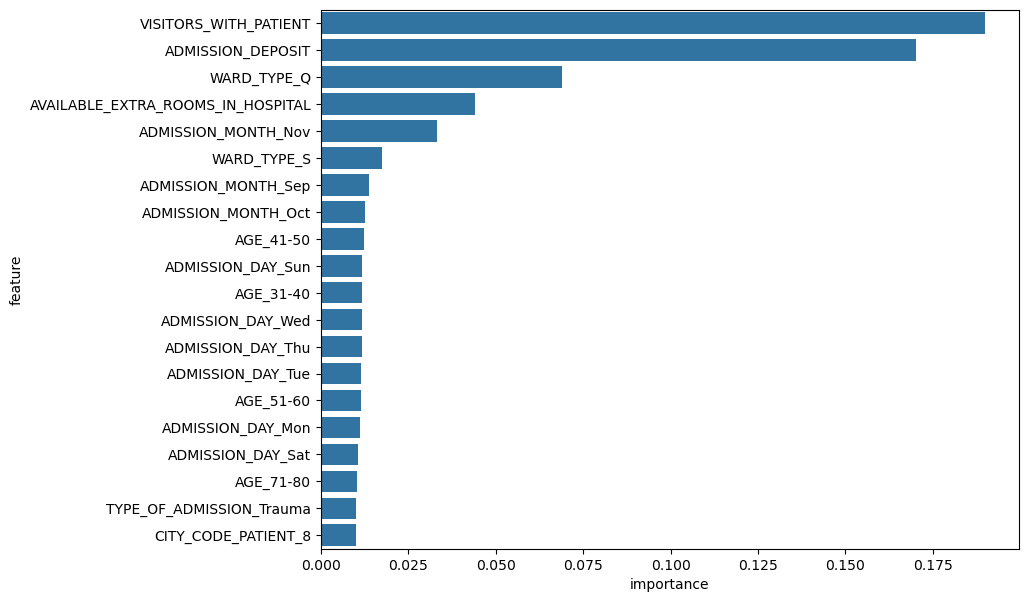

In [33]:
# Feature Importance
feat_imp = (pd.DataFrame(zip(x_train.columns,dtree.feature_importances_),columns=['feature','importance'])
            .sort_values(by='importance',ascending=False))
display(feat_imp[:20])

plt.figure(figsize=(9,7))
sns.barplot(y='feature',x='importance',data=feat_imp[:20],orient='h')
plt.show()

In [28]:
# Selecting features with atleast 1% importance value
display(feat_imp[feat_imp['importance']>=0.01])
final_features_dtree = feat_imp[feat_imp['importance']>=0.01]['feature'].values.tolist()
print(len(final_features_dtree))
final_features_dtree[:5]

,feature,importance
1,VISITORS_WITH_PATIENT,0.195471
2,ADMISSION_DEPOSIT,0.170136
25,WARD_TYPE_Q,0.069969
0,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.045313
88,ADMISSION_MONTH_Nov,0.034071
27,WARD_TYPE_S,0.013793
89,ADMISSION_MONTH_Oct,0.012854
90,ADMISSION_MONTH_Sep,0.012651
82,AGE_41-50,0.011920
92,ADMISSION_DAY_Sat,0.011864


19


['VISITORS_WITH_PATIENT',
 'ADMISSION_DEPOSIT',
 'WARD_TYPE_Q',
 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL',
 'ADMISSION_MONTH_Nov']

#### 2. XGB Selection: 

In [29]:
import xgboost as xgb

xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

0.421082079410553

,feature,importance
25,AGE_31-40,0.237141
1,ADMISSION_DAY_Tue,0.059019
14,ADMISSION_DEPOSIT,0.028101
9,ADMISSION_DAY_Wed,0.010875
0,ADMISSION_MONTH_Nov,0.008883
18,VISITORS_WITH_PATIENT,0.007427
17,ADMISSION_DAY_Mon,0.006520
22,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.006506
3,WARD_TYPE_R,0.005705
13,CITY_CODE_HOSPITAL_2,0.005557


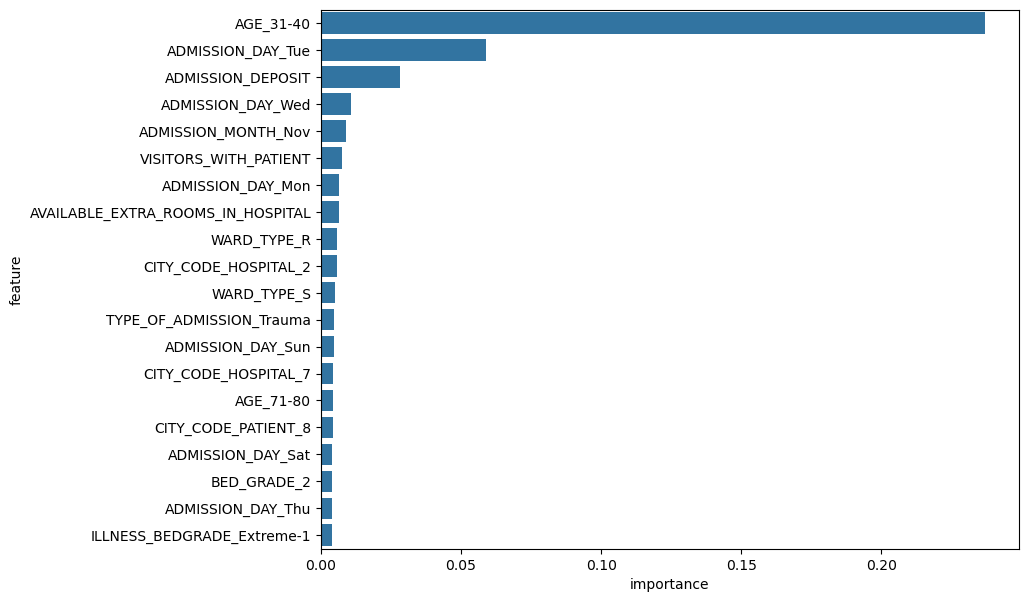

In [43]:
# Feature Importance
feat_imp = (pd.DataFrame(zip(x_train.columns,xgb_.feature_importances_),columns=['feature','importance'])
            .sort_values(by='importance',ascending=False))
display(feat_imp[:20])

plt.figure(figsize=(9,7))
sns.barplot(y='feature',x='importance',data=feat_imp[:20],orient='h')
plt.show()

In [31]:
# Selecting features with atleast 1% importance value
display(feat_imp[feat_imp['importance']>=0.01][:10])
final_features_xgb = feat_imp[feat_imp['importance']>=0.01]['feature'].values.tolist()
print(len(final_features_xgb))
final_features_xgb[:5]

,feature,importance
25,WARD_TYPE_Q,0.237141
88,ADMISSION_MONTH_Nov,0.076534
1,VISITORS_WITH_PATIENT,0.059019
75,TYPE_OF_ADMISSION_Trauma,0.035102
77,SEVERITY_OF_ILLNESS_Minor,0.028289
14,CITY_CODE_HOSPITAL_7,0.028101
27,WARD_TYPE_S,0.023780
89,ADMISSION_MONTH_Oct,0.022654
36,BED_GRADE_2,0.020519
105,ILLNESS_BEDGRADE_Extreme-1,0.019946


13


['WARD_TYPE_Q',
 'ADMISSION_MONTH_Nov',
 'VISITORS_WITH_PATIENT',
 'TYPE_OF_ADMISSION_Trauma',
 'SEVERITY_OF_ILLNESS_Minor']

#### Feature Union: 

In [32]:
print("Total Features from Dtree: "+str(len(final_features_dtree)))
print("Total Features from XGB: "+str(len(final_features_xgb)))

Total Features from Dtree: 19
Total Features from XGB: 13


In [33]:
model_features =  list(set(final_features_dtree).union(set(final_features_xgb)))
print("Final Features from both Dtree & XGB: "+str(len(model_features)))

Final Features from both Dtree & XGB: 26


In [34]:
model_features

['ADMISSION_MONTH_Nov',
 'ADMISSION_DAY_Tue',
 'ADMISSION_MONTH_Oct',
 'WARD_TYPE_R',
 'CITY_CODE_HOSPITAL_7',
 'WARD_TYPE_Q',
 'ADMISSION_DAY_Sat',
 'AGE_41-50',
 'WARD_TYPE_S',
 'ADMISSION_DAY_Wed',
 'ADMISSION_MONTH_Sep',
 'BED_GRADE_2',
 'ILLNESS_BEDGRADE_Extreme-1',
 'CITY_CODE_HOSPITAL_2',
 'ADMISSION_DEPOSIT',
 'TYPE_OF_ADMISSION_Trauma',
 'AGE_51-60',
 'ADMISSION_DAY_Mon',
 'VISITORS_WITH_PATIENT',
 'ADMISSION_DAY_Sun',
 'CITY_CODE_PATIENT_8',
 'ADMISSION_DAY_Thu',
 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL',
 'SEVERITY_OF_ILLNESS_Minor',
 'AGE_71-80',
 'AGE_31-40']

In [55]:
df_final[model_features+['LOS']].to_pickle('MODEL_training_data_with_final_features.pkl')

In [56]:
import pickle

final_feats_list = model_features+['LOS']

with open('MODEL_FEATS.pkl','wb') as F:
    pickle.dump(final_feats_list,F)

In [54]:
df_final

,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,VISITORS_WITH_PATIENT,ADMISSION_DEPOSIT,LOS,HOSPITAL_TYPE_CODE_b,HOSPITAL_TYPE_CODE_c,HOSPITAL_TYPE_CODE_d,HOSPITAL_TYPE_CODE_e,HOSPITAL_TYPE_CODE_f,HOSPITAL_TYPE_CODE_g,CITY_CODE_HOSPITAL_2,CITY_CODE_HOSPITAL_3,CITY_CODE_HOSPITAL_4,CITY_CODE_HOSPITAL_5,CITY_CODE_HOSPITAL_6,CITY_CODE_HOSPITAL_7,CITY_CODE_HOSPITAL_9,CITY_CODE_HOSPITAL_10,CITY_CODE_HOSPITAL_11,CITY_CODE_HOSPITAL_13,HOSPITAL_REGION_CODE_Y,HOSPITAL_REGION_CODE_Z,DEPARTMENT_anesthesia,DEPARTMENT_gynecology,DEPARTMENT_radiotherapy,DEPARTMENT_surgery,WARD_TYPE_Q,WARD_TYPE_R,WARD_TYPE_S,WARD_TYPE_T,WARD_TYPE_U,WARD_FACILITY_CODE_B,WARD_FACILITY_CODE_C,WARD_FACILITY_CODE_D,WARD_FACILITY_CODE_E,WARD_FACILITY_CODE_F,BED_GRADE_1,BED_GRADE_2,BED_GRADE_3,BED_GRADE_4,CITY_CODE_PATIENT_1,CITY_CODE_PATIENT_2,CITY_CODE_PATIENT_3,CITY_CODE_PATIENT_4,CITY_CODE_PATIENT_5,CITY_CODE_PATIENT_6,CITY_CODE_PATIENT_7,CITY_CODE_PATIENT_8,CITY_CODE_PATIENT_9,CITY_CODE_PATIENT_10,CITY_CODE_PATIENT_11,CITY_CODE_PATIENT_12,CITY_CODE_PATIENT_13,CITY_CODE_PATIENT_14,CITY_CODE_PATIENT_15,CITY_CODE_PATIENT_16,CITY_CODE_PATIENT_18,CITY_CODE_PATIENT_19,CITY_CODE_PATIENT_20,CITY_CODE_PATIENT_21,CITY_CODE_PATIENT_22,CITY_CODE_PATIENT_23,CITY_CODE_PATIENT_24,CITY_CODE_PATIENT_25,CITY_CODE_PATIENT_26,CITY_CODE_PATIENT_27,CITY_CODE_PATIENT_28,CITY_CODE_PATIENT_29,CITY_CODE_PATIENT_30,CITY_CODE_PATIENT_31,CITY_CODE_PATIENT_32,CITY_CODE_PATIENT_33,CITY_CODE_PATIENT_34,CITY_CODE_PATIENT_35,CITY_CODE_PATIENT_36,CITY_CODE_PATIENT_37,TYPE_OF_ADMISSION_Trauma,TYPE_OF_ADMISSION_Urgent,SEVERITY_OF_ILLNESS_Minor,SEVERITY_OF_ILLNESS_Moderate,AGE_20-Nov,AGE_21-30,AGE_31-40,AGE_41-50,AGE_51-60,AGE_61-70,AGE_71-80,AGE_81-90,AGE_91-100,ADMISSION_MONTH_Nov,ADMISSION_MONTH_Oct,ADMISSION_MONTH_Sep,ADMISSION_DAY_Mon,ADMISSION_DAY_Sat,ADMISSION_DAY_Sun,ADMISSION_DAY_Thu,ADMISSION_DAY_Tue,ADMISSION_DAY_Wed,ADMISSION_ILLNESS_Emergency-Minor,ADMISSION_ILLNESS_Emergency-Moderate,ADMISSION_ILLNESS_Trauma-Extreme,ADMISSION_ILLNESS_Trauma-Minor,ADMISSION_ILLNESS_Trauma-Moderate,ADMISSION_ILLNESS_Urgent-Extreme,ADMISSION_ILLNESS_Urgent-Minor,ADMISSION_ILLNESS_Urgent-Moderate,ILLNESS_BEDGRADE_Extreme-1,ILLNESS_BEDGRADE_Extreme-2,ILLNESS_BEDGRADE_Extreme-3,ILLNESS_BEDGRADE_Extreme-4,ILLNESS_BEDGRADE_Minor-0,ILLNESS_BEDGRADE_Minor-1,ILLNESS_BEDGRADE_Minor-2,ILLNESS_BEDGRADE_Minor-3,ILLNESS_BEDGRADE_Minor-4,ILLNESS_BEDGRADE_Moderate-0,ILLNESS_BEDGRADE_Moderate-1,ILLNESS_BEDGRADE_Moderate-2,ILLNESS_BEDGRADE_Moderate-3,ILLNESS_BEDGRADE_Moderate-4,DEPARTMENT_ILLNESS_TB & Chest disease-Minor,DEPARTMENT_ILLNESS_TB & Chest disease-Moderate,DEPARTMENT_ILLNESS_anesthesia-Extreme,DEPARTMENT_ILLNESS_anesthesia-Minor,DEPARTMENT_ILLNESS_anesthesia-Moderate,DEPARTMENT_ILLNESS_gynecology-Extreme,DEPARTMENT_ILLNESS_gynecology-Minor,DEPARTMENT_ILLNESS_gynecology-Moderate,DEPARTMENT_ILLNESS_radiotherapy-Extreme,DEPARTMENT_ILLNESS_radiotherapy-Minor,DEPARTMENT_ILLNESS_radiotherapy-Moderate,DEPARTMENT_ILLNESS_surgery-Extreme,DEPARTMENT_ILLNESS_surgery-Minor,DEPARTMENT_ILLNESS_surgery-Moderate
CASE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,2,4911,10,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,2,2,4745,40,False,

## Model Building:

In [37]:
from sklearn.model_selection import train_test_split

df_features = pd.read_pickle('MODEL_training_data_with_final_features.pkl')
print(df_features.shape)
df_features.head(3)

(236704, 27)


,ADMISSION_MONTH_Nov,ADMISSION_DAY_Tue,ADMISSION_MONTH_Oct,WARD_TYPE_R,CITY_CODE_HOSPITAL_7,WARD_TYPE_Q,ADMISSION_DAY_Sat,AGE_41-50,WARD_TYPE_S,ADMISSION_DAY_Wed,ADMISSION_MONTH_Sep,BED_GRADE_2,ILLNESS_BEDGRADE_Extreme-1,CITY_CODE_HOSPITAL_2,ADMISSION_DEPOSIT,TYPE_OF_ADMISSION_Trauma,AGE_51-60,ADMISSION_DAY_Mon,VISITORS_WITH_PATIENT,ADMISSION_DAY_Sun,CITY_CODE_PATIENT_8,ADMISSION_DAY_Thu,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,SEVERITY_OF_ILLNESS_Minor,AGE_71-80,AGE_31-40,LOS
CASE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,True,False,False,False,False,False,True,False,True,False,False,4911,False,True,False,2,False,False,False,3,False,False,False,10
3,False,False,False,False,False,False,False,False,True,False,True,True,False,False,4745,True,True,False,2,False,False,False,2,False,False,False,40
4,False,False,False,True,False,False,False,False,False,False,True,True,False,True,7272,True,True,False,2,False,False,True,2,False,False,False,50


In [39]:
# Train and Test split
X = df_features.drop('LOS',axis=1)
y = df_features[['LOS']]
print(X.shape,y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=123)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(236704, 26) (236704, 1)
(165692, 26) (165692, 1)
(71012, 26) (71012, 1)


### 1. Linear Regression:

In [44]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_train,y_train)

0.18143520430239823

In [45]:
preds = np.ceil(lr.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  15.22963692330309
MAE:  3.374968575848166


### 2. Random Forest Regression:

In [46]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train,y_train)
rf.score(x_train,y_train)

0.8992820049455491

In [47]:
preds = np.ceil(rf.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  14.276292891568495
MAE:  3.2524812984811344


In [48]:
preds

array([34., 25., 32., ..., 36., 39., 31.])

### 3. XGB Regression:

In [49]:
import xgboost as xgb

xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

0.3967684507369995

In [50]:
preds = np.ceil(xgb_.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  13.628718175437605
MAE:  3.171957373736798


In [52]:
# Saving the trained model
booster = xgb_.get_booster()
booster.save_model('MODEL_XGB.model')